In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
assignment_path = "/content/drive/My Drive/Urban/"
sys.path.append(assignment_path)

In [3]:
!pip install python-dateutil
!pip install pysal --quiet
from pysal.explore import esda
from pysal.lib import weights
from libpysal.weights.raster import da2W

     |████████████████████████████████| 2.4 MB 5.4 MB/s 
     |████████████████████████████████| 95 kB 3.5 MB/s 
     |████████████████████████████████| 60 kB 7.3 MB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 164 kB 52.4 MB/s 
     |████████████████████████████████| 46 kB 3.7 MB/s 
     |████████████████████████████████| 41 kB 584 kB/s 
     |████████████████████████████████| 209 kB 50.4 MB/s 
     |████████████████████████████████| 5.7 MB 12.5 MB/s 
     |████████████████████████████████| 81 kB 8.2 MB/s 
     |████████████████████████████████| 138 kB 58.4 MB/s 
     |████████████████████████████████| 226 kB 50.3 MB/s 
     |████████████████████████████████| 269 kB 58.0 MB/s 
     |████████████████████████████████| 66.5 MB 106 kB/s 
     |████████████████████████████████| 2.1 MB 31.5 MB/s 
     |████████████████████████████████| 183 kB 48.1 MB/s 
     |████████████████████████████████| 117 kB 50.3 MB/s 
     |█████████████████████

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geo

In [4]:
!pip install git+git://github.com/geopandas/geopandas.git

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-liqa27bj
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-liqa27bj
  Created wheel for geopandas: filename=geopandas-0.10.2+16.gee8adfb-py2.py3-none-any.whl size=1031775 sha256=1a54db97c673b381c91a705bfbb77d48cd61e751a3419b69fe63f773338927b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-it15kqh4/wheels/cf/3e/0b/6475054094c2b1ea054158ac1fdcf749fb92f5b512377e4cf8
Successfully built geopandas
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.10.2
    Uninstalling geopandas-0.10.2:
      Successfully uninstalled geopandas-0.10.2


In [5]:
import os, sys
import pandas as pd
import geopandas
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import datetime as date
import warnings
from datetime import datetime
from dateutil import parser
from datetime import timedelta
import pytz

sys.path.insert(0,'../')
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

In [85]:
dt = pd.read_csv('/content/drive/My Drive/Urban/Data/311_City_Service_Requests_in_2020.csv', parse_dates=['ADDDATE', 'RESOLUTIONDATE', 'SERVICEDUEDATE', 'SERVICEORDERDATE', 'INSPECTIONDATE'])

cutoffDate = pd.to_datetime(date.date(2020,4,1))
tz = pytz.timezone("UTC")
cutoffDate = tz.localize(cutoffDate)

#Just change which one to comment out in checking:
# GRAFF                                                Graffiti Removal
#dt=dt[dt['SERVICECODE']=='GRAFF']
# S0011                                                  Alley Cleaning
dt=dt[dt['SERVICECODE']=='S0011']
# S0196                                          Leaf Season Collection
#dt=dt[dt['SERVICECODE']=='S0196']
dt.head(5)
print(dt)

                X          Y  OBJECTID  ... MARADDRESSREPOSITORYID WARD DETAILS
237    -76.986600  38.868658      1454  ...               286024.0  8.0     NaN
340    -76.965989  38.876869      1557  ...               805626.0  7.0     NaN
355    -76.986582  38.903771      1572  ...                69056.0  5.0     NaN
384    -77.007515  38.917943      1601  ...                29587.0  5.0     NaN
442    -77.026347  38.948836      1659  ...               252071.0  4.0     NaN
...           ...        ...       ...  ...                    ...  ...     ...
304487 -76.974470  38.871372    658994  ...                50641.0  8.0     NaN
304527 -76.976860  38.900877    659034  ...               803768.0  5.0     NaN
304600 -77.005967  38.912395    659107  ...                72867.0  5.0     NaN
304639 -76.926284  38.903552    659146  ...               901845.0  7.0     NaN
304690 -76.975621  38.898991    659197  ...                54162.0  5.0     NaN

[5402 rows x 30 columns]


In [86]:
#Doesn't always form the same clusters with the xi implementation
geoGRAFF=dt[['LATITUDE', 'LONGITUDE']]
eps=0.01
clusterGRAFF=OPTICS(max_eps=eps, min_samples=3).fit(geoGRAFF)

In [87]:
cluster_labels = clusterGRAFF.labels_
num_clusters = len(set(cluster_labels))
reach = clusterGRAFF.reachability_[clusterGRAFF.ordering_]
#print(openCleanupCluster.core_distances_)

labels = clusterGRAFF.labels_

numclusters = len(np.unique(labels) )
numnoise = np.sum(np.array(labels) == -1, axis=0)

print('Clusters: %d' % numclusters)
print('Noise: %d' % numnoise)
print('Reachability: %s' % reach)

Clusters: 870
Noise: 1208
Reachability: [       inf 0.         0.         ...        inf 0.0055491  0.00379812]


In [88]:
openGRAFFs=clusterGRAFF.fit_predict(geoGRAFF)
dt['cluster']=openGRAFFs
dt=dt[dt['cluster']>-1]
print(dt)

                X          Y  OBJECTID  ... WARD DETAILS cluster
237    -76.986600  38.868658      1454  ...  8.0     NaN       0
340    -76.965989  38.876869      1557  ...  7.0     NaN      46
355    -76.986582  38.903771      1572  ...  5.0     NaN     435
384    -77.007515  38.917943      1601  ...  5.0     NaN     550
442    -77.026347  38.948836      1659  ...  4.0     NaN     658
...           ...        ...       ...  ...  ...     ...     ...
304487 -76.974470  38.871372    658994  ...  8.0     NaN      41
304527 -76.976860  38.900877    659034  ...  5.0     NaN     369
304600 -77.005967  38.912395    659107  ...  5.0     NaN     528
304639 -76.926284  38.903552    659146  ...  7.0     NaN     121
304690 -76.975621  38.898991    659197  ...  5.0     NaN     376

[4194 rows x 31 columns]


In [89]:
# After sorting the values we can check it temporaly near its neighbors by seeing if it falls within ADDDATE and RESOLUTIONDATE, then look to see if it's RESOLUTIONDATE is within 8 hours of the neighbor.
# This is horribly inefficient and would be a terrible solution to sacle up to the country level, however it's only purpose is to detect whether the DPW considers jobs spatially nearby when scheduling 
# so needs to be run only once per type tested.  An alternative implementation would be a kNN or similar but with points in time treated as distances.
clusterCount=dt.groupby(['cluster'])['X'].count()
dt=dt.sort_values(by=['cluster', 'ADDDATE'])
dt['notQueued']=-1
dt=dt.reset_index(drop=True)
for i in range(1,len(dt.index)):
  for j in range(1, clusterCount.iloc[dt['cluster'].iloc[i]]):
    if(dt['cluster'].iloc[i]==dt['cluster'].iloc[i-j]):
      if(dt['RESOLUTIONDATE'].iloc[i-j] > dt['ADDDATE'].iloc[i]):
        try:
          if(pd.isnull(dt['RESOLUTIONDATE'].iloc[0])):
            dt['notQueued'].iloc[i]=1
          if(dt['notQueued'].iloc[i]!=0):
            if(np.abs(dt['RESOLUTIONDATE'].iloc[i-1] - dt['RESOLUTIONDATE'].iloc[i]).total_seconds() > 28800.0):
              if(distance.euclidean((dt['LONGITUDE'].iloc[i-1],dt['LATITUDE'].iloc[i-1]),(dt['LONGITUDE'].iloc[i],dt['LATITUDE'].iloc[i]))<=eps): #possible for 2 edges of the cluster to be further away than max_eps, this accounts for that
                dt['notQueued'].iloc[i]=1
              else:
                dt['notQueued'].iloc[i]=-1
            else:
              dt['notQueued'].iloc[i]=0
              dt['notQueued'].iloc[i-j]=0 #Giving the DPW the benefit of the doubt so as long as it is grouped up with at least 1 other request even if not the most optimal grouping that's still "okay"
        except:
          dt['notQueued'].iloc[i]=-1

print("Those not being done together:")
print(dt[dt['notQueued']==1])
#dt[dt['notQueued']==1].tail(10)

print("Those being done together:")
print(dt[dt['notQueued']==0])

print("Those isolated time wise and couldn't be grouped:")
print(dt[dt['notQueued']==-1])
#dt.head(15)

Those not being done together:
              X          Y  OBJECTID  ... DETAILS cluster notQueued
2    -76.986600  38.868658    215708  ...     NaN       0         1
7    -76.985679  38.868695    422553  ...     NaN       1         1
11   -76.984837  38.868418    306442  ...     NaN       2         1
23   -76.983295  38.867759    636153  ...     NaN       4         1
28   -76.984747  38.865065    456133  ...     NaN       5         1
...         ...        ...       ...  ...     ...     ...       ...
4144 -77.088114  38.955784    331207  ...     NaN     856         1
4145 -77.087959  38.955781    457293  ...     NaN     856         1
4157 -77.065799  38.956425    285517  ...     NaN     859         1
4175 -77.065149  38.964714    409513  ...     NaN     863         1
4189 -77.085085  38.908211    130847  ...     NaN     867         1

[945 rows x 32 columns]
Those being done together:
              X          Y  OBJECTID  ... DETAILS cluster notQueued
9    -76.984944  38.868418    242

In [90]:
# This was just me confirming that 2 points could be further away than max_eps in the same cluster
from scipy.spatial import distance
for i in range(1,len(dt.index)):
  x=distance.euclidean((dt['LONGITUDE'].iloc[i-1],dt['LATITUDE'].iloc[i-1]),(dt['LONGITUDE'].iloc[i],dt['LATITUDE'].iloc[i]))
  if(x>eps):
    if(dt['cluster'].iloc[i-1]==dt['cluster'].iloc[i]):
      stri=str(i) + ' cluster ' + str(dt['cluster'].iloc[i]) + ' dist: ' + str(x)
      print(stri)

In [92]:
!pip install IPython

In [93]:
import geopandas as gpd

In [94]:
!pip install contextily
import contextily as cx

In [134]:
gdfDPWclustering = gpd.GeoDataFrame(dt, geometry=gpd.points_from_xy(dt.LONGITUDE, dt.LATITUDE), crs='EPSG:4326')
#DPWclusteringGDF=df.sjoin(gdfDPWclustering, how="right")
gdfDPWclustering=gdfDPWclustering[gdfDPWclustering['cluster']==840]
gdfDPWclustering=gdfDPWclustering[gdfDPWclustering['notQueued']!=-1] #Removing these to keep it simple for the image
#DPWClusteringMean=(DPWclusteringGDF.groupby(['GEOID', 'CLUSTER'], as_index=False)['DURATION'].mean())
print(gdfDPWclustering)

              X          Y  ...  notQueued                    geometry
4058 -77.010439  38.874785  ...          0  POINT (-77.01044 38.87478)
4059 -77.009734  38.872179  ...          0  POINT (-77.00973 38.87217)
4060 -77.017012  38.871808  ...          0  POINT (-77.01701 38.87180)
4061 -77.017012  38.871808  ...          0  POINT (-77.01701 38.87180)
4062 -77.009724  38.875178  ...          1  POINT (-77.00972 38.87517)
4063 -77.010650  38.873807  ...          1  POINT (-77.01065 38.87380)
4066 -77.009724  38.875178  ...          1  POINT (-77.00972 38.87517)
4069 -77.012625  38.873129  ...          1  POINT (-77.01262 38.87312)

[8 rows x 33 columns]


(-8573534.81824367, -8572642.481761975, 4703300.547240189, 4703830.637627266)

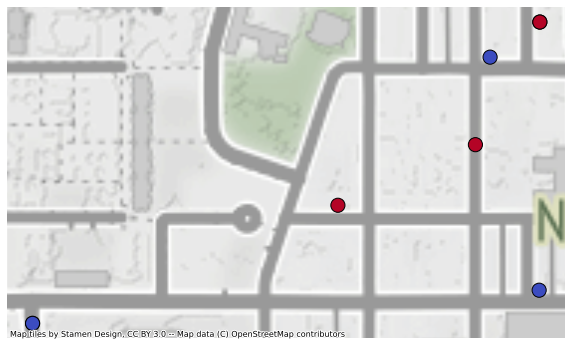

In [132]:
dfMap = gdfDPWclustering.to_crs(epsg=3857)
#i=DPWclusteringGDF[DPWclusteringGDF['OBJECTID_left']==5]
topMap = dfMap.to_crs(epsg=3857)

mapper = topMap.plot(figsize=(10, 10), alpha=1, edgecolor='k', markersize=200, column="notQueued", colormap="coolwarm")
cx.add_basemap(mapper, zoom=15)
plt.axis('off')